In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from scipy.spatial import KDTree, cKDTree
from shapely.geometry import LineString, Point
from haversine import haversine, Unit 
from pyproj import Transformer, Proj, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [2]:
from pathlib import Path
input_folder = Path('boundary_conditions')
output_folder = Path('boundary_conditions/preprocessed_WL')

1. Loading WL Boundary Polyline (Same as Wave Maker in IWS Scenario)

In [3]:
epsg = 32736
bc_file_path = input_folder / 'gis' / 'wavemaker.gpkg'
bc_df = gpd.read_file(bc_file_path).to_crs(epsg=epsg)

2. Make the BC Line to Have At Least One Point for Every 1000 m (Same as GCC) and Then Project to WGS84

In [4]:
# Function to approximate points along a polyline
def approximate_points(line, distance=1000):
    length = line.length
    points = [line.interpolate(d) for d in range(0, int(length) + distance, distance)]
    return [(point.y, point.x) for point in points]

bc_coords = bc_df.geometry.apply(
    lambda geom: approximate_points(geom) if isinstance(geom, LineString) else None
)
bc_coords = [coords for coords in bc_coords if coords is not None]
bc_coords_flat = [pt for sublist in bc_coords for pt in sublist]

# Convert bc_coords_flat from UTM to WGS84
# Function to approximate points along a polyline
transformer_to_wgs84 = Transformer.from_crs("EPSG:32736", "EPSG:4326", always_xy=True)
bc_coords_flat = [transformer_to_wgs84.transform(x, y) for y, x in bc_coords_flat]

print(bc_coords_flat)

[(34.823050232362085, -20.35607475572104), (34.82659582553295, -20.347684285899312), (34.83014106829027, -20.339293765705005), (34.83368596090517, -20.33090319523803), (34.837230503648684, -20.32251257459824), (34.84077469679176, -20.314121903885553), (34.844318540605286, -20.305731183199793), (34.84786203536006, -20.297340412640793), (34.851405181326804, -20.288949592308395), (34.85494797877615, -20.28055872230238), (34.858490427978666, -20.27216780272256), (34.86203252920483, -20.263776833668697), (34.86554048368101, -20.255374547880344), (34.86836933695457, -20.24674593910135), (34.871197915620755, -20.23811730124721), (34.87402621991144, -20.229488634384623), (34.876854250058436, -20.220859938580233), (34.8796820062935, -20.212231213900704), (34.88250948884828, -20.203602460412682), (34.88533669795439, -20.19497367818279), (34.88816363384337, -20.186344867277665), (34.89099029674666, -20.17771602776389), (34.893816686895654, -20.1690871597081), (34.89664280452166, -20.1604582631768

3. Import Nearest ERA5 Wave Value

In [5]:
era5_file_path = input_folder / 'wave' / 'era5_wave_preprocessed.nc'
era5_ds = xr.open_dataset(era5_file_path)

era5_ds.load()

<xarray.Dataset> Size: 30kB
Dimensions:  (time: 744, index: 1)
Coordinates:
    number   int64 8B 0
  * time     (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
    y        (index) float64 8B -20.2
    x        (index) float64 8B 35.2
    expver   (time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Dimensions without coordinates: index
Data variables:
    wd       (time, index) float32 3kB 109.4 110.6 111.7 ... 131.5 131.4 131.4
    tp       (time, index) float32 3kB 5.437 5.547 5.627 ... 5.351 5.37 5.389
    hs       (time, index) float32 3kB 0.6595 0.6376 0.6181 ... 0.6759 0.6815
    ds       (time, index) float32 3kB 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T15:14 GRIB to CDM+CF via cfgrib-0.9.1...
    crs:                     EPSG:4326

In [6]:
swh = era5_ds['hs']
pp1d = era5_ds['tp']
lats = era5_ds['y'].values 
lons = era5_ds['x'].values 
times = era5_ds['time'].values

# Function to find the nearest index for a given value in an array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

swh_values = []
pp1d_values = []
for lat, lon in bc_coords_flat:
    lat_idx = find_nearest(lats, lat)
    lon_idx = find_nearest(lons, lon)
    
    if 'y' in swh.dims and 'x' in swh.dims:
        swh_at_point = swh[:, lat_idx, lon_idx]
        pp1d_at_point = pp1d[:, lat_idx, lon_idx]
    else:
        # If only a single index is available, fall back to using this
        swh_at_point = swh[:, 0]
        pp1d_at_point = pp1d[:, 0]
    
    swh_values.append(swh_at_point.values)
    pp1d_values.append(pp1d_at_point.values)

swh_values = np.stack(swh_values)
pp1d_values = np.stack(pp1d_values)

swh_ds = xr.Dataset(
    {
        "swh": (("location", "time"), swh_values),
        "pp1d": (("location", "time"), pp1d_values),
    },
    coords={
        "latitude": ("location", [pt[0] for pt in bc_coords_flat]),
        "longitude": ("location", [pt[1] for pt in bc_coords_flat]),
        "time": times,
        "location": range(len(bc_coords_flat)),
    }
)

In [7]:
swh_ds

<xarray.Dataset> Size: 669kB
Dimensions:    (location: 111, time: 744)
Coordinates:
    latitude   (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
    longitude  (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
  * time       (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
  * location   (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    swh        (location, time) float32 330kB 0.6595 0.6376 ... 0.6759 0.6815
    pp1d       (location, time) float32 330kB 5.437 5.547 5.627 ... 5.37 5.389

4. Import Nearest DFM WL

In [8]:
dfm_file_path = r'C:\Intern\SFINCS_Sofala\boundary_conditions\DFM_output\mozambique_spw_Idai_areaBeira_500m_gebco2023_map.nc'
dfm_ds = xr.open_dataset(dfm_file_path)

# Extract the water level (mesh2d_s1), mesh2d_face_y (latitude), mesh2d_face_x (longitude), and time from the DFM dataset
water_level = dfm_ds['mesh2d_s1'] 
lats = dfm_ds['mesh2d_face_y'].values
lons = dfm_ds['mesh2d_face_x'].values 
times = dfm_ds['time'].values  

coordinates = np.column_stack([lons, lats])
tree = KDTree(coordinates)


water_level_values = []
latitudes = []
longitudes = []
for lon, lat in bc_coords_flat:
    dist, idx = tree.query([lon, lat])
    water_level_at_point = water_level[:, idx] 

    water_level_values.append(water_level_at_point.values)
    latitudes.append(lat)
    longitudes.append(lon)

water_level_values = np.array(water_level_values)

wl_ds = xr.Dataset(
    {
        "water_level": (("location", "time"), water_level_values)
    },
    coords={
        "latitude": ("location", latitudes),
        "longtitude": ("location", longitudes),
        "time": times,
        "location": range(len(bc_coords_flat)),
    }
)

In [9]:
wl_ds

<xarray.Dataset> Size: 154kB
Dimensions:      (location: 111, time: 169)
Coordinates:
    latitude     (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
    longtitude   (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
  * time         (time) datetime64[ns] 1kB 2019-03-09 ... 2019-03-16
  * location     (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    water_level  (location, time) float64 150kB 0.0 -0.003464 ... 0.2766 0.01589

5. Import GCC Points (No NaN)

In [10]:
# Load the CSV file (Global Coastal Dataset)
csv_file_path = input_folder / "GCC" / "GCC_geophysical.csv"

# Load the dataset
gcc_df = pd.read_csv(csv_file_path)

# Drop rows where 'ns' has NaN values, but keep rows with valid 'lon' and 'lat'
gcc_df = gcc_df[['lon', 'lat', 'ns', 'bs_deltadtm', 'cs_deltadtm']].dropna(subset=['ns'])
gcc_gdf = gpd.GeoDataFrame(gcc_df, geometry=gpd.points_from_xy(gcc_df['lon'], gcc_df['lat']), crs="EPSG:4326")

In [11]:
gcc_gdf

,lon,lat,ns,bs_deltadtm,cs_deltadtm,geometry
0,6.629669,0.408872,0.00862,0.06029,0.01448,POINT (6.62967 0.40887)
1,6.620820,0.407340,0.01684,0.06619,0.03041,POINT (6.62082 0.40734)
2,6.612525,0.404036,0.01781,0.27550,0.03367,POINT (6.61252 0.40404)
3,6.605409,0.398530,0.01945,1.51832,0.12190,POINT (6.60541 0.39853)
4,6.598725,0.392495,0.03598,0.30299,0.18257,POINT (6.59872 0.3925)
...,...,...,...,...,...,...
728083,-26.290341,-58.412925,0.08179,0.23435,0.22389,POINT (-26.29034 -58.41292)
728084,-26.304023,-58.407747,0.06723,1.15492,0.25425,POINT (-26.30402 -58.40775)
728085,-26.320893,-58.406344,0.02666,4.31900,0.16351,POINT (-26.32089 -58.40634)
728086,-26.337913,-58.405414,0.02678,0.43683,0.23099,POINT (-26.33791 -58.40541)


6. Approximate GCC Value in Each WL BC using IDW Method

In [12]:
# Build a KDTree for fast nearest-neighbor search using WGS 84 coordinates in gcc_gdf
tree = cKDTree(gcc_gdf[['lon', 'lat']].values)

longitude_list = []
latitude_list = []
beta_values = []
beta_f_values = []
combined_beta_values = []

# Set a distance threshold in meters (e.g., 10 km = 10,000 meters)
distance_threshold_meters = 50000  # Adjust the threshold as needed

# For each coordinate in bc_coords_wgs84, find the two nearest points in the dataset and interpolate
for lon, lat in bc_coords_flat:
    dists, idxs = tree.query([lon, lat], k=2)  

    # Convert the nearest point distances from degrees to meters using Haversine if needed
    nearest_coords = gcc_gdf.iloc[idxs][['lon', 'lat']].values
    distances_meters = [haversine((lat, lon), (lat_nearest, lon_nearest), unit='m') 
                        for lon_nearest, lat_nearest in nearest_coords]

    # Filter valid points within the distance threshold
    valid_idx = [i for i, dist in enumerate(distances_meters) if dist <= distance_threshold_meters]

    if len(valid_idx) > 0: 
        valid_distances = np.array(distances_meters)[valid_idx]
        valid_ns_values = gcc_gdf.iloc[idxs[valid_idx]]['ns'].values
        valid_bs_values = gcc_gdf.iloc[idxs[valid_idx]]['bs_deltadtm'].values
        valid_cs_values = gcc_gdf.iloc[idxs[valid_idx]]['cs_deltadtm'].values

        # Calculate weights based on inverse of distances (closer points get more weight)
        weights = 1 / valid_distances
        total_weight = np.sum(weights)
        ns_value = np.dot(valid_ns_values, weights) / total_weight
        bs_value = np.dot(valid_bs_values, weights) / total_weight
        cs_value = np.dot(valid_cs_values, weights) / total_weight
    else:
        ns_value = np.nan 
        bs_value = np.nan
        cs_value = np.nan

    longitude_list.append(lon)
    latitude_list.append(lat)
    beta_f_values.append(ns_value)
    beta_values.append(bs_value)
    combined_beta_values.append(cs_value)

beta_df = pd.DataFrame({
    'longitude': longitude_list,
    'latitude': latitude_list,
    'beta': beta_values,
    'beta_f': beta_f_values,
    'cs': combined_beta_values
}).reset_index(drop=True)

print(beta_df)

     longitude   latitude      beta    beta_f        cs
0    34.823050 -20.356075  0.007532  0.000661  0.001368
1    34.826596 -20.347684  0.029871  0.000995  0.001895
2    34.830141 -20.339294  0.029856  0.000995  0.001895
3    34.833686 -20.330903  0.015264  0.001025  0.001625
4    34.837231 -20.322513  0.014217  0.001359  0.002228
..         ...        ...       ...       ...       ...
106  35.329998 -19.563565  0.017025  0.002963  0.003184
107  35.336894 -19.557334  0.029871  0.003358  0.003831
108  35.343789 -19.551104  0.030317  0.003817  0.004396
109  35.350684 -19.544873  0.011050  0.003330  0.003446
110  35.356489 -19.539626  0.004024  0.002597  0.002563

[111 rows x 5 columns]


7. Calculate Stockdon Runup

In [13]:
# Function to calculate wave length
def cal_wave_length(wave_period_array):
    return 9.81 * wave_period_array**2 / (2 * np.pi)

setup_list = []
inc_swash_list = []
ig_swash_list = []
swash_list = []
total_runup_list = []

for i in range(len(swh_ds['location'])):
    swh = swh_ds['swh'].isel(location=i)
    pp1d = swh_ds['pp1d'].isel(location=i)
    wave_length = cal_wave_length(pp1d)
    
    beta_value = beta_df['beta'][i]
    beta_f_value = beta_df['beta_f'][i]
    cs_value = beta_df['cs'][i]
    
    if np.isnan(beta_f_value):
            setup = swh * 0.0
            inc_swash = swh * 0.0
            ig_swash = swh * 0.0
            swash = swh * 0.0
            total_runup = swh * 0
    else:
         setup = 0.35 * (beta_f_value) * (swh * wave_length)**0.5
         inc_swash = 0.75 * beta_value * (swh * wave_length)**0.5
         ig_swash = 0.06 * (swh * wave_length)**0.5
        #  swash = (inc_swash + ig_swash)/2
         swash = (swh * wave_length * (0.563 * beta_value**2 + 0.004)) ** 0.5
         total_runup = 1.1* (setup + swash/2)
    
    setup_list.append(setup)
    inc_swash_list.append(inc_swash)
    ig_swash_list.append(ig_swash)
    swash_list.append(swash)
    total_runup_list.append(total_runup)

setup_array = xr.concat(setup_list, dim='location')
inc_swash_array = xr.concat(inc_swash_list, dim='location')
ig_swash_array = xr.concat(ig_swash_list, dim='location')
swash_array = xr.concat(swash_list, dim='location')
total_runup_array = xr.concat(total_runup_list, dim='location')

setup_array_data = setup_array.data
inc_swash_array_data = inc_swash_array.data
ig_swash_array_data = ig_swash_array.data
swash_array_data = swash_array.data
total_runup_array_data = total_runup_array.data

stockdon_result_ds = xr.Dataset(
    {
        'setup': (('location', 'time'), setup_array_data * 1.1), # to represent the setrup component of the total runup hence needs to be multiplied by 1.1
        'inc_swash': (('location', 'time'), inc_swash_array_data),
        'ig_swash': (('location', 'time'), ig_swash_array_data),
        'swash' : (('location', 'time'), swash_array_data * 1.1 / 2),  # to represent the swash component of the total runup hence needs to be divided by 2 and multiplied by 1.1
        'total_runup': (('location', 'time'), total_runup_array_data)
    },
    coords={
        'latitude': swh_ds['latitude'],
        'longitude': swh_ds['longitude'],
        'time': swh_ds['time'],
        'location': swh_ds['location']
    }
)

In [14]:
stockdon_result_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (location: 111, time: 744)
Coordinates:
    latitude     (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
    longitude    (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
  * location     (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
  * time         (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
Data variables:
    setup        (location, time) float32 330kB 0.001404 0.001409 ... 0.005558
    inc_swash    (location, time) float32 330kB 0.03117 0.03127 ... 0.01678
    ig_swash     (location, time) float32 330kB 0.331 0.3321 ... 0.331 0.3336
    swash        (location, time) float32 330kB 0.1927 0.1933 ... 0.1921 0.1936
    total_runup  (location, time) float32 330kB 0.1941 0.1947 ... 0.1976 0.1992

8. Combining DFM WL and Stockdon Runup

In [15]:
stockdon_subset = stockdon_result_ds.sel(time=slice(wl_ds['time'].min(), wl_ds['time'].max()))

# Now, combine the water level and SWH datasets using the formula: combined_wl = wl + 0.2 * swh
combined_wl = wl_ds['water_level'] + stockdon_subset['total_runup']

waterlevel_data = combined_wl.transpose("time", "location").values
time_values = combined_wl['time'].values
lat_values = wl_ds['latitude'].values
long_values = wl_ds['longtitude'].values
point_index = np.arange(len(lat_values))

combined_ds = xr.Dataset(
    {
        "waterlevel": (("time", "location"), waterlevel_data)  
    },
    coords={
        "time": time_values,                   
        "location": point_index,                   
        "lat": ("location", lat_values),           
        "long": ("location", long_values)           
    }
)


# Save the result as a new NetCDF file
combined_output_path = output_folder / 'stockdon_WL.nc'
combined_ds.to_netcdf(combined_output_path)

print(f"Combined WL and SWH data saved to {combined_output_path}")

Combined WL and SWH data saved to boundary_conditions\preprocessed_WL\stockdon_WL.nc


In [16]:
combined_ds

<xarray.Dataset> Size: 154kB
Dimensions:     (time: 169, location: 111)
Coordinates:
  * time        (time) datetime64[ns] 1kB 2019-03-09 ... 2019-03-16
  * location    (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
    lat         (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
    long        (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
Data variables:
    waterlevel  (time, location) float64 150kB 0.2575 0.273 ... 0.361 0.355

See How it compares with 0.2 Hs

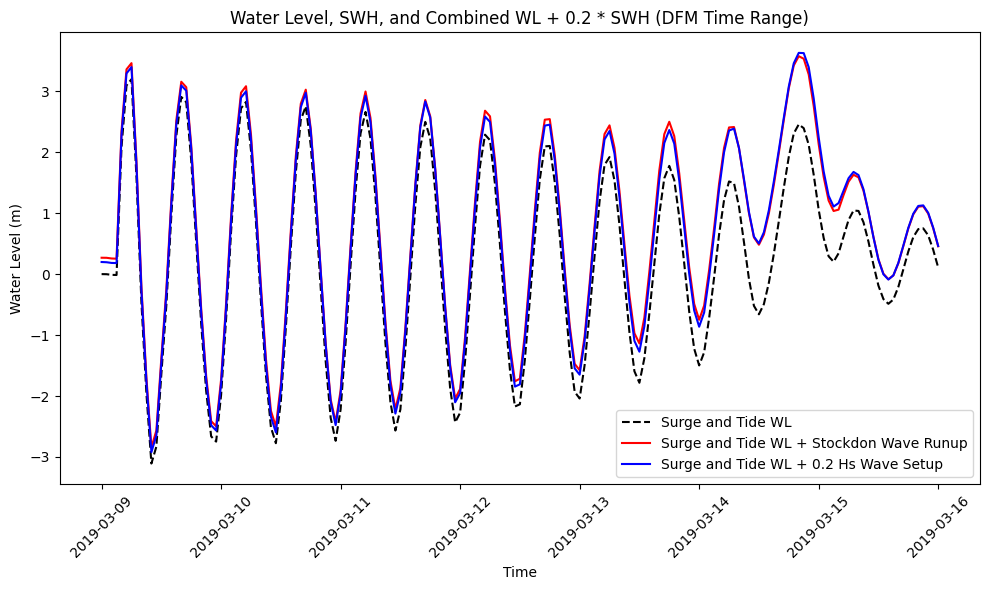

In [17]:
simple_output_path =  output_folder / '0.2hs_WL.nc'
combine_simple_ds = xr.open_dataset(simple_output_path)

# Choose a location (e.g., the first location in the dataset)
location = 5  # Adjust the location index if needed

dfm_time = wl_ds['time']
start_time = dfm_time.min().values
end_time = dfm_time.max().values

combined_stockdon = combined_ds['waterlevel'].isel(location=location).sel(time=slice(start_time, end_time))
combined_simple = combine_simple_ds['waterlevel'].isel(location=location).sel(time=slice(start_time, end_time))
original_wl = wl_ds['water_level'].isel(location=location).sel(time=slice(start_time, end_time))
time = original_wl['time']

plt.figure(figsize=(10, 6))
plt.plot(time, original_wl, label='Surge and Tide WL', color='k', linestyle="dashed")
plt.plot(time, combined_stockdon, label='Surge and Tide WL + Stockdon Wave Runup', color='red')
plt.plot(time, combined_simple, label='Surge and Tide WL + 0.2 Hs Wave Setup', color='blue')
plt.title('Water Level, SWH, and Combined WL + 0.2 * SWH (DFM Time Range)')
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

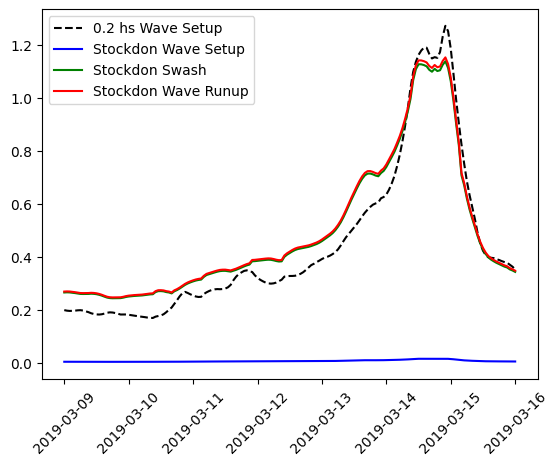

In [18]:
setup_only = stockdon_result_ds['setup'].isel(location=location).sel(time=slice(start_time, end_time))
swash_only = stockdon_result_ds['swash'].isel(location=location).sel(time=slice(start_time, end_time))
runup = stockdon_result_ds['total_runup'].isel(location=location).sel(time=slice(start_time, end_time))
simple_setup_only = swh_ds['swh'].isel(location=location).sel(time=slice(start_time, end_time))


# Plot significant wave height
plt.plot(time, simple_setup_only * 0.2, label='0.2 hs Wave Setup', color='black', linestyle='--')
plt.plot(time, setup_only, label='Stockdon Wave Setup', color='blue')
plt.plot(time, swash_only, label='Stockdon Swash', color='green')
plt.plot(time, runup, label='Stockdon Wave Runup', color='red')
plt.xticks(rotation=45)
plt.legend()

C:\Users\gradiyan\AppData\Local\Temp\ipykernel_30944\1523198960.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_coords, y_coords = transform(wgs84, web_mercator, lons, lats)


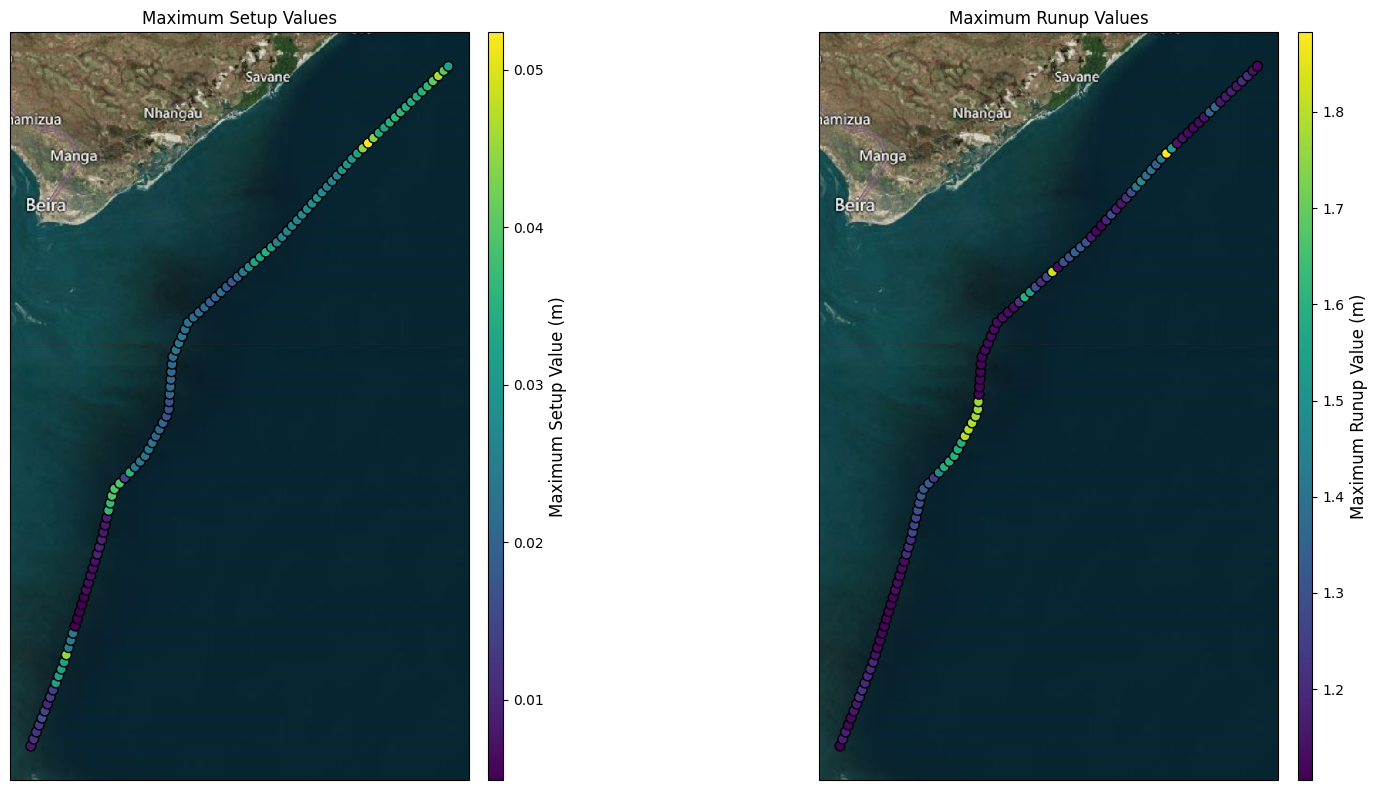

In [19]:
wgs84 = Proj("EPSG:4326") 
web_mercator = Proj("EPSG:3857")

lats = swh_ds['latitude'].values
lons = swh_ds['longitude'].values
x_coords, y_coords = transform(wgs84, web_mercator, lons, lats)

max_setup_values = stockdon_result_ds['setup'].max(dim='time').values  
max_runup_values = stockdon_result_ds['total_runup'].max(dim='time').values
setup_norm = mcolors.Normalize(vmin=np.min(max_setup_values), vmax=np.max(max_setup_values))
runup_norm = mcolors.Normalize(vmin=np.min(max_runup_values), vmax=np.max(max_runup_values))
cmap = cm.viridis

esri_imagery = cimgt.QuadtreeTiles()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8), subplot_kw={'projection': ccrs.Mercator()})
ax1.set_title("Maximum Setup Values")
ax1.add_image(esri_imagery, 10)
sc1 = ax1.scatter(x_coords, y_coords, c=max_setup_values, cmap=cmap, norm=setup_norm, s=50, edgecolor='k', transform=ccrs.Mercator())
cbar1 = plt.colorbar(sc1, ax=ax1, orientation='vertical', pad=0.02, aspect=50)
cbar1.set_label('Maximum Setup Value (m)', fontsize=12)

ax2.set_title("Maximum Runup Values")
ax2.add_image(esri_imagery, 10)
sc2 = ax2.scatter(x_coords, y_coords, c=max_runup_values, cmap=cmap, norm=runup_norm, s=50, edgecolor='k', transform=ccrs.Mercator())
cbar2 = plt.colorbar(sc2, ax=ax2, orientation='vertical', pad=0.02, aspect=50)
cbar2.set_label('Maximum Runup Value (m)', fontsize=12)

plt.tight_layout()
plt.show()

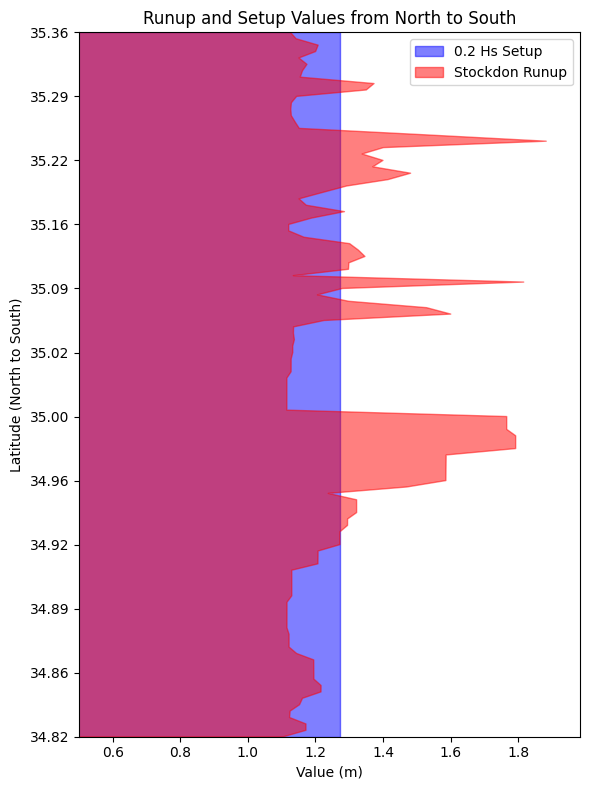

In [20]:
location = slice(0, len(swh_ds['latitude']))  # All locations
runup = stockdon_result_ds['total_runup'].isel(location=location).max(dim='time')
setup = swh_ds['swh'].isel(location=location).max(dim='time') * 0.2
latitude = swh_ds['latitude'].values
data = pd.DataFrame({'Latitude': latitude, 'Runup': runup.values, 'Setup': setup.values})
data = data.sort_values(by='Latitude', ascending=False)  # Sort from north to south

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

x = np.arange(len(data))

ax.fill_betweenx(x, data['Setup'], color='blue', alpha=0.5, label='0.2 Hs Setup')
ax.fill_betweenx(x, data['Runup'], color='red', alpha=0.5, label='Stockdon Runup')

ax.invert_yaxis()

ax.set_yticks(x)
ax.set_yticklabels([f"{lat:.2f}" for lat in data['Latitude']], rotation=0)
ax.set_yticks([i for i in range(len(data)) if i % int(0.05 / abs(data['Latitude'].diff().mean())) == 0])
ax.set_ylabel("Latitude (North to South)")
ax.set_xlabel("Value (m)")
ax.set_title("Runup and Setup Values from North to South")
ax.legend()


ax.set_xlim(0.5, max(data[['Runup', 'Setup']].max()) + 0.1)
ax.set_ylim(len(data)-1, 0) 

plt.tight_layout()
plt.show()
